# Домашнее задание №1

## 1. Добиться вразумительного результата от модели, собранной на занятии (7 угаданныx картинок из 10 предложенных на семинаре). Варианты изменений:
*   изменение слоёв и их количества;
*   изменение метода оптимизации;
*   изменение процесса обучения; 
*   для продвинутых: преобразование данных transform

In [1]:
!pip3 install torch torchvision
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [2]:
import torch
import torchvision
import numpy as np
from torch import nn 
from torch import optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt ### воспользуемся для отображения изображения

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
train_transform = transforms.Compose(
    [transforms.RandomRotation(10),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

In [5]:
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,  
                                             transform=train_transform, 
                                             download=True)


image, label = train_dataset[0]
print (image.size())
print (label)

Extracting ../../data/cifar-10-python.tar.gz to ../../data/
torch.Size([3, 32, 32])
6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


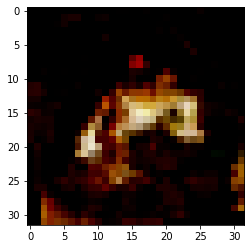

In [7]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [9]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10,
                                         shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.dropout1(self.fc1(x)))
        x = F.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
num_epochs = 12
plot_interval = 100

In [14]:
len(train_loader)

782

In [15]:
total_train_step = len(train_loader)
total_test_step = len(test_loader)
for epoch in range(num_epochs):
    sum_loss = 0.0
    sum_correct = 0
    sum_total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        sum_correct += correct
        sum_total += total

        # выводим статистику о процессе обучения
        sum_loss += loss.item()
        
        if (i + 1) % plot_interval == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_train_step, sum_loss/plot_interval,
                          (sum_correct / sum_total) * 100))
            sum_loss = 0.0
            sum_correct = 0
            sum_total = 0
    
    # На каждой эпохе выводим точность и потери на тестовом наборе
    net.eval()
    with torch.no_grad():
      sum_loss = 0.0
      sum_correct = 0
      sum_total = 0
      for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        sum_total += total

        correct = (predicted == labels).sum().item()
        sum_correct += correct

      print('Test Loss: {:.4f}; Test Аccuracy: {:.2f} %'.format((sum_loss / total_test_step), (sum_correct / sum_total * 100)))
    net.train()


print('Training is finished!')

Epoch [1/12], Step [100/782], Loss: 2.0078, Accuracy: 23.86%
Epoch [1/12], Step [200/782], Loss: 1.7279, Accuracy: 34.62%
Epoch [1/12], Step [300/782], Loss: 1.6089, Accuracy: 40.14%
Epoch [1/12], Step [400/782], Loss: 1.5136, Accuracy: 44.36%
Epoch [1/12], Step [500/782], Loss: 1.4645, Accuracy: 47.05%
Epoch [1/12], Step [600/782], Loss: 1.4063, Accuracy: 49.53%
Epoch [1/12], Step [700/782], Loss: 1.3308, Accuracy: 52.62%
Test Loss: 1.1347; Test Аccuracy: 58.94 %
Epoch [2/12], Step [100/782], Loss: 1.2283, Accuracy: 56.55%
Epoch [2/12], Step [200/782], Loss: 1.2333, Accuracy: 56.12%
Epoch [2/12], Step [300/782], Loss: 1.1592, Accuracy: 58.97%
Epoch [2/12], Step [400/782], Loss: 1.1593, Accuracy: 60.28%
Epoch [2/12], Step [500/782], Loss: 1.1220, Accuracy: 60.77%
Epoch [2/12], Step [600/782], Loss: 1.1078, Accuracy: 61.09%
Epoch [2/12], Step [700/782], Loss: 1.0738, Accuracy: 63.05%
Test Loss: 0.8982; Test Аccuracy: 67.36 %
Epoch [3/12], Step [100/782], Loss: 1.0170, Accuracy: 65.11%
E

In [16]:
net.eval()
with torch.no_grad():
  sum_loss = 0.0
  sum_correct = 0
  sum_total = 0
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    sum_loss += loss
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    sum_total += total

    correct = (predicted == labels).sum().item()
    sum_correct += correct

  print('Test Loss: {:.4f}; Test Аccuracy: {:.2f} %'.format((sum_loss / total_test_step), (sum_correct / sum_total * 100)))
#net.train()

Test Loss: 0.6346; Test Аccuracy: 79.92 %


In [17]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

labels = labels.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car


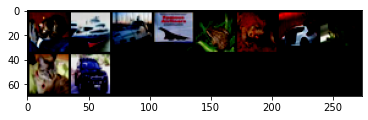

In [18]:
imgs = torchvision.utils.make_grid(images)
images = images.to(device)
outputs = net(images)

plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

Predicted:    cat  ship  ship plane  frog  frog   car  frog   cat   car


## 2. Переписать данный туториал на pytorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [20]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader

In [21]:
num_epochs = 5 
num_classes = 10 
batch_size = 100 
learning_rate = 0.001
# Место, куда будет сохранен датасет
DATA_PATH = 'data'
MODEL_STORE_PATH = '.'

In [22]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) 

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True) 
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [23]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
class ConvNet(nn.Module): 
    def __init__(self): 
        super(ConvNet, self).__init__() 
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
# Определяем последовательность прямого прохода

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [28]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Прямой запуск
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [100/600], Loss: 0.1216, Accuracy: 96.00%
Epoch [1/5], Step [100/600], Loss: 0.1216, Accuracy: 96.00%
Epoch [1/5], Step [200/600], Loss: 0.1295, Accuracy: 93.00%
Epoch [1/5], Step [200/600], Loss: 0.1295, Accuracy: 93.00%
Epoch [1/5], Step [300/600], Loss: 0.1414, Accuracy: 97.00%
Epoch [1/5], Step [300/600], Loss: 0.1414, Accuracy: 97.00%
Epoch [1/5], Step [400/600], Loss: 0.0553, Accuracy: 98.00%
Epoch [1/5], Step [400/600], Loss: 0.0553, Accuracy: 98.00%
Epoch [1/5], Step [500/600], Loss: 0.1788, Accuracy: 94.00%
Epoch [1/5], Step [500/600], Loss: 0.1788, Accuracy: 94.00%
Epoch [1/5], Step [600/600], Loss: 0.1152, Accuracy: 97.00%
Epoch [1/5], Step [600/600], Loss: 0.1152, Accuracy: 97.00%
Epoch [2/5], Step [100/600], Loss: 0.1159, Accuracy: 97.00%
Epoch [2/5], Step [100/600], Loss: 0.1159, Accuracy: 97.00%
Epoch [2/5], Step [200/600], Loss: 0.0759, Accuracy: 96.00%
Epoch [2/5], Step [200/600], Loss: 0.0759, Accuracy: 96.00%
Epoch [2/5], Step [300/600], Loss: 0.112

In [30]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 99.19 %
